In [1]:
import hashlib
import os
import tarfile # 处理tar、gz后缀压缩包专用
import zipfile # 处理zip文件专用
import requests
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
os.path.join('..', 'data')

'../data'

- 下⾯的download函数⽤来下载数据集，将数据集缓存在本地⽬录（默认情况下为../data）中，并返回下
载⽂件的名称。如果缓存⽬录中已经存在此数据集⽂件，并且其sha-1与存储在DATA_HUB中的相匹配，我们
将使⽤缓存的⽂件，以避免重复的下载。

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')): #@save
    """下载⼀个DATA_HUB中的⽂件，返回本地⽂件名。"""
    assert name in DATA_HUB, f"{name} 不存在于{DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        # sha1是一种哈希加密算法
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
                
        if sha1.hexdigest() == sha1_hash:
            return fname # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

- 我们还实现了两个额外的实⽤函数：⼀个是下载并解压缩⼀个zip或tar⽂件，另⼀个是将本书中使⽤的所有
数据集从DATA_HUB下载到缓存⽬录中。

In [4]:
def download_extract(name, folder=None): #@save
    """下载并解压zip/tar⽂件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    # os.path.splitext：分离文件名与扩展名；默认返回(fname,fextension)元组，可做分片操作
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar⽂件可以被解压缩。'
    # 压缩文件
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): #@save
    """下载DATA_HUB中的所有⽂件。"""
    for name in DATA_HUB:
        download(name)

- 接下来从kaggle下载数据

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

- 为⽅便起⻅，我们可以使⽤上⾯定义的脚本下载并缓存Kaggle房屋数据集。

In [6]:
DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv',
                                  '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv',
                                 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

- 我们使⽤pandas分别加载包含训练数据和测试数据的两个CSV⽂件。

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

- 数据预处理
  - 数据归一化
  - $$x \rightarrow \frac{x-\mu}{\sigma}$$

In [10]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有数据都意味着消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

- 独热编码
  - pandas软件包会⾃动为我们实现这⼀点
  - 整体进行实现

In [11]:
# `Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指⽰符特征。
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

- 接下来将pandas格式转换为numpy格式
- 再numpy转换为tensor格式

In [12]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=d2l.float32)
train_labels = torch.tensor(train_data['SalePrice'].values.reshape(-1, 1), dtype=d2l.float32)

In [13]:
train_features.shape,test_features.shape,train_labels.shape

(torch.Size([1460, 331]), torch.Size([1459, 331]), torch.Size([1460, 1]))

- nn.MSEloss()为$loss(x_i,y_i) = (x_i - y_i)^2$

In [14]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

- 这里定义了一个新的指标
  - 主要是因为房价差距范围较大，取对数后能缩小范围
  - $\sigma = \sqrt{\frac{1}{n}\sum_{i=1}^n(log y_i - log \hat{y}_i)^2}$

In [15]:
def log_rmse(net, features, labels):
    # 为了在取对数时进⼀步稳定该值，将⼩于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [16]:
# 举例,torch.clamp函数会将目标函数的数值强制取值在一定范围内
# 下例b限制了范围为3-6
torch.manual_seed(2)
a=torch.randint(low=0,high=10,size=(3,3))
print(a)
b=torch.clamp(a,3,6)
print(b)

tensor([[8, 7, 1],
        [4, 8, 9],
        [2, 5, 0]])
tensor([[6, 6, 3],
        [4, 6, 6],
        [3, 5, 3]])


- 训练函数将借助Adam优化器。这个优化器的主
要优势在于，初始学
习率不那么敏感。

In [17]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这⾥使⽤的是Adam优化算法，代替之前的SGD算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

- 定义kfold交叉验证

In [18]:
# 此函数能够将数据切分，返回数据集和验证集
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # 这个slice和常规切片方式没有什么不同
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

- 当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [19]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # 
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch',
                     ylabel='rmse',
                     xlim=[1, num_epochs],
                     legend=['train', 'valid'],
                     yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.170600, valid log rmse 0.156993
fold 2, train log rmse 0.162377, valid log rmse 0.188829
fold 3, train log rmse 0.163685, valid log rmse 0.168139
fold 4, train log rmse 0.167824, valid log rmse 0.154402
fold 5, train log rmse 0.163068, valid log rmse 0.182763
5-折验证: 平均训练log rmse: 0.165511, 平均验证log rmse: 0.170225


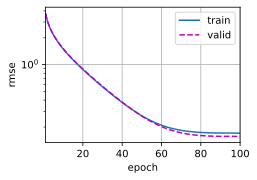

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')

- 在超参数确以后，我们可以把所有数据进行一次训练
- 并把训练结果进行提交

In [21]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls],
             xlabel='epoch',
             ylabel='log rmse',
             xlim=[1, num_epochs],
             yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将⽹络应⽤于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.162770


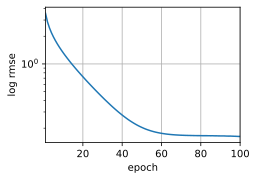

In [22]:
train_and_pred(train_features, test_features, train_labels, test_data,num_epochs, lr, weight_decay, batch_size)